In [1]:
# !pip install mlflow dagshub
import zipfile
import os
import itertools
import matplotlib.pylab as plt
import mlflow
import mlflow.keras
import dagshub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Navigate to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Human_Action_Recognition.zip'

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

dataset_path = '/content/dataset/'
print("Root contents:", os.listdir(dataset_path))

# Explore the structured folder
structured_path = '/content/dataset/Structured'
print("\nStructured folder contents:", os.listdir(structured_path))

# Check train and test folders
train_path = os.path.join(structured_path, 'train')
test_path = os.path.join(structured_path, 'test')

print(f"\nTrain folder contents: {os.listdir(train_path)}")
print(f"Test folder contents: {os.listdir(test_path)}")

Root contents: ['Structured']

Structured folder contents: ['test', 'train']

Train folder contents: ['running', 'clapping', 'calling', 'cycling', 'hugging', 'texting', 'using_laptop', 'sitting', 'eating', 'drinking', 'fighting', 'sleeping', 'dancing', 'laughing', 'listening_to_music']
Test folder contents: ['running', 'clapping', 'calling', 'cycling', 'hugging', 'texting', 'using_laptop', 'sitting', 'eating', 'drinking', 'fighting', 'sleeping', 'dancing', 'laughing', 'listening_to_music']


In [6]:
def create_action_recognition_dataset():
    structured_path = '/content/dataset/Structured'
    train_path = os.path.join(structured_path, 'train')
    test_path = os.path.join(structured_path, 'test')

    # Automatically discover class names from train folder
    CLASS_NAMES = sorted(os.listdir(train_path))
    print("Discovered action classes:", CLASS_NAMES)

    # Create datasets using Keras
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(128,128),
        batch_size=16,
        shuffle=True
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(128,128),
        batch_size=16,
        shuffle=False
    )

    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    return train_dataset, test_dataset, CLASS_NAMES

In [7]:
train_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

print(f"\nDataset created successfully!")
print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Classes: {CLASS_NAMES}")
print(f"Train batches: {len(train_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.

Dataset created successfully!
Number of classes: 15
Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Train batches: 670
Test batches: 119


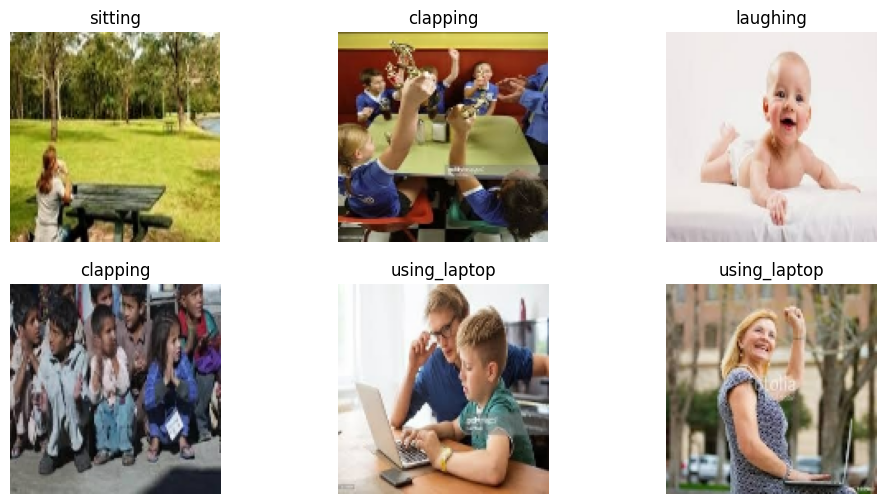

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        display_image = (images[i].numpy() * 255).astype("uint8")

        plt.imshow(display_image)
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')
    plt.show()

In [9]:
def plot_training(history):
    """Simple plot function"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [10]:
DAGSHUB_USERNAME = "Arej02"
DAGSHUB_REPO_NAME = "Human_Action_Recognition"

# Setup DagsHub connection
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME,mlflow=True)

# Set MLflow tracking to DagsHub
mlflow.set_tracking_uri(f"https://dagshub.com/Arej02/Human_Action_Recognition.mlflow")

Accessing as Arej02

Initialized MLflow to track repo "Arej02/Human_Action_Recognition"

Repository Arej02/Human_Action_Recognition initialized!

In [11]:
mlflow.set_experiment("Transfer Learning Using VGG16")

<Experiment: artifact_location='mlflow-artifacts:/3bb9d023fb9c4c1b9d77092d3fa18ab1', creation_time=1764586911317, experiment_id='2', last_update_time=1764586911317, lifecycle_stage='active', name='Transfer Learning Using VGG16', tags={}>

In [12]:
def train_action_recognition():
  with mlflow.start_run(run_name="Vgg16_v1"):

    train_dataset,test_dataset,CLASS_NAME=create_action_recognition_dataset()
    base_model=VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(128,128,3)
    )
    base_model.trainable=False

    model=Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(len(CLASS_NAME),activation="softmax")
      ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

    history=model.fit(
          train_dataset,
          validation_data=test_dataset,
          epochs=10,
          verbose=1
      )

    final_train_accuracy=history.history["accuracy"][-1] #Last epoch
    final_test_accuracy=history.history["val_accuracy"][-1]
    final_train_loss=history.history["loss"][-1]
    final_test_loss=history.history["val_loss"][-1]

    mlflow.log_metric("Train Accuracy:",final_train_accuracy)
    mlflow.log_metric("Test Accuracy:",final_test_accuracy)
    mlflow.log_metric("Train Loss:",final_train_loss)
    mlflow.log_metric("Test Loss:",final_test_loss)

    plot_training(history)

    return final_train_accuracy,final_test_accuracy,final_train_loss,final_test_loss



Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Epoch 1/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.1626 - loss: 2.7667 - val_accuracy: 0.3894 - val_loss: 1.8703
Epoch 2/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.2995 - loss: 2.1534 - val_accuracy: 0.4402 - val_loss: 1.7316
Epoch 3/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.3462 - loss: 2.0191 - val_accuracy: 0.4577 - val_loss: 1.6738
Epoch 4/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.3810 - loss: 1.9410 - val_accuracy: 0.4693 - val_loss: 1.6498
Epoch 5/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.4071 - loss: 1.8628 - val_accuracy: 0.4836 - val_loss: 1.5974
Epoch 6/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/ste

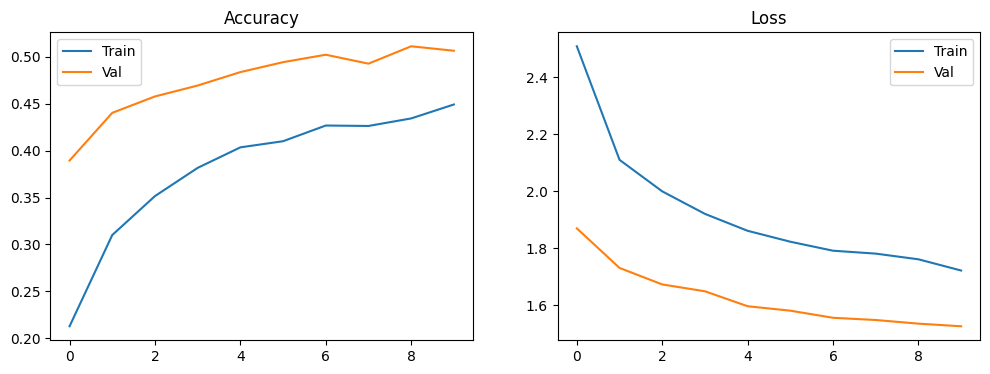

🏃 View run Vgg16_v1 at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/2/runs/04ba3589fe0d4b5ab4a4e1aa2b3f6c89
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/2
Final training accuracy: 0.44911298155784607
Final validation accuracy: 0.5063492059707642


In [13]:
def main():
  final_train_accuracy,final_test_accuracy,final_train_loss,final_test_loss = train_action_recognition()
  print("Final training accuracy:",final_train_accuracy)
  print("Final validation accuracy:",final_test_accuracy)

if __name__ == "__main__":
    main()

In [ ]:
mlflow.set_experiment("Transfer Learning Using VGG16 (Fine-tuning)")

In [14]:
def train_action_recognition():
  with mlflow.start_run(run_name="Vgg16_v1"):

    train_dataset,test_dataset,CLASS_NAME=create_action_recognition_dataset()
    base_model=VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(128,128,3)
    )
    base_model.trainable=False

    fine_tune_at = 15  # Unfreeze last 4 layers

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model=Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(len(CLASS_NAME),activation="softmax")
      ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

    history=model.fit(
          train_dataset,
          validation_data=test_dataset,
          epochs=10,
          verbose=1
      )

    final_train_accuracy=history.history["accuracy"][-1] #Last epoch
    final_test_accuracy=history.history["val_accuracy"][-1]
    final_train_loss=history.history["loss"][-1]
    final_test_loss=history.history["val_loss"][-1]

    mlflow.log_metric("Train Accuracy:",final_train_accuracy)
    mlflow.log_metric("Test Accuracy:",final_test_accuracy)
    mlflow.log_metric("Train Loss:",final_train_loss)
    mlflow.log_metric("Test Loss:",final_test_loss)

    plot_training(history)

    return final_train_accuracy,final_test_accuracy,final_train_loss,final_test_loss



Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Epoch 1/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.1453 - loss: 2.7838 - val_accuracy: 0.2598 - val_loss: 2.4550
Epoch 2/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.3241 - loss: 2.0545 - val_accuracy: 0.3857 - val_loss: 1.7686
Epoch 3/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.3943 - loss: 1.8363 - val_accuracy: 0.4233 - val_loss: 1.8081
Epoch 4/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.4515 - loss: 1.6914 - val_accuracy: 0.4820 - val_loss: 1.6354
Epoch 5/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.4965 - loss: 1.5470 - val_accuracy: 0.4656 - val_loss: 1.7371
Epoch 6/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/ste

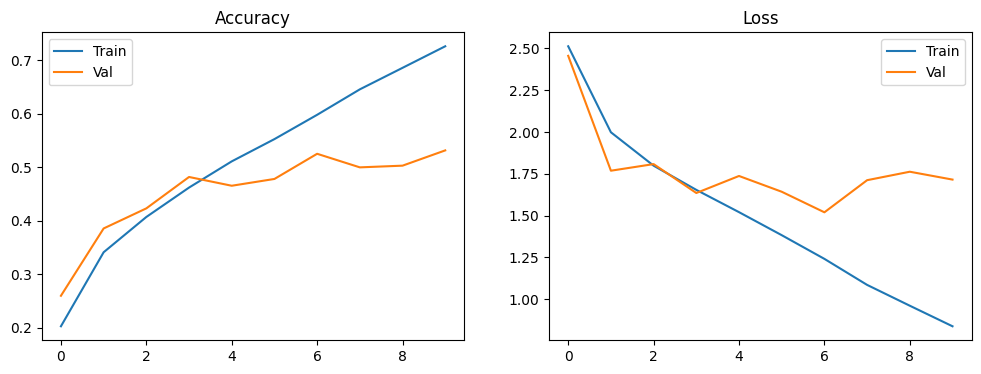

🏃 View run Vgg16_v1 at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/2/runs/332d9db58b6145e58da18d5159d86b04
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/2
Final training accuracy: 0.7265172600746155
Final validation accuracy: 0.5317460298538208


In [15]:
def main():
  final_train_accuracy,final_test_accuracy,final_train_loss,final_test_loss = train_action_recognition()
  print("Final training accuracy:",final_train_accuracy)
  print("Final validation accuracy:",final_test_accuracy)

if __name__ == "__main__":
    main()